Using the algorithms from this paper: https://arxiv.org/pdf/2304.09224v2


In [ ]:
# imports
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Softmax
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import pennylane as qml
import tensorflow as tf
import pennylane.numpy as pnp
import sys
import os

## Overall structure

```
ALGORITHM: HQNN-Parallel
INPUT: Image x of size 28×28 (for MNIST)
OUTPUT: Class probability distribution over 10 classes

FUNCTION HQNN_Parallel(x):
    // Classical Convolutional Feature Extraction
    features = ClassicalConvolutionalBlock(x)

    // Hybrid Dense Processing
    quantum_output = ParallelQuantumLayers(features)

    // Final Classification
    output = ClassicalDenseLayer(quantum_output)

    RETURN output
```

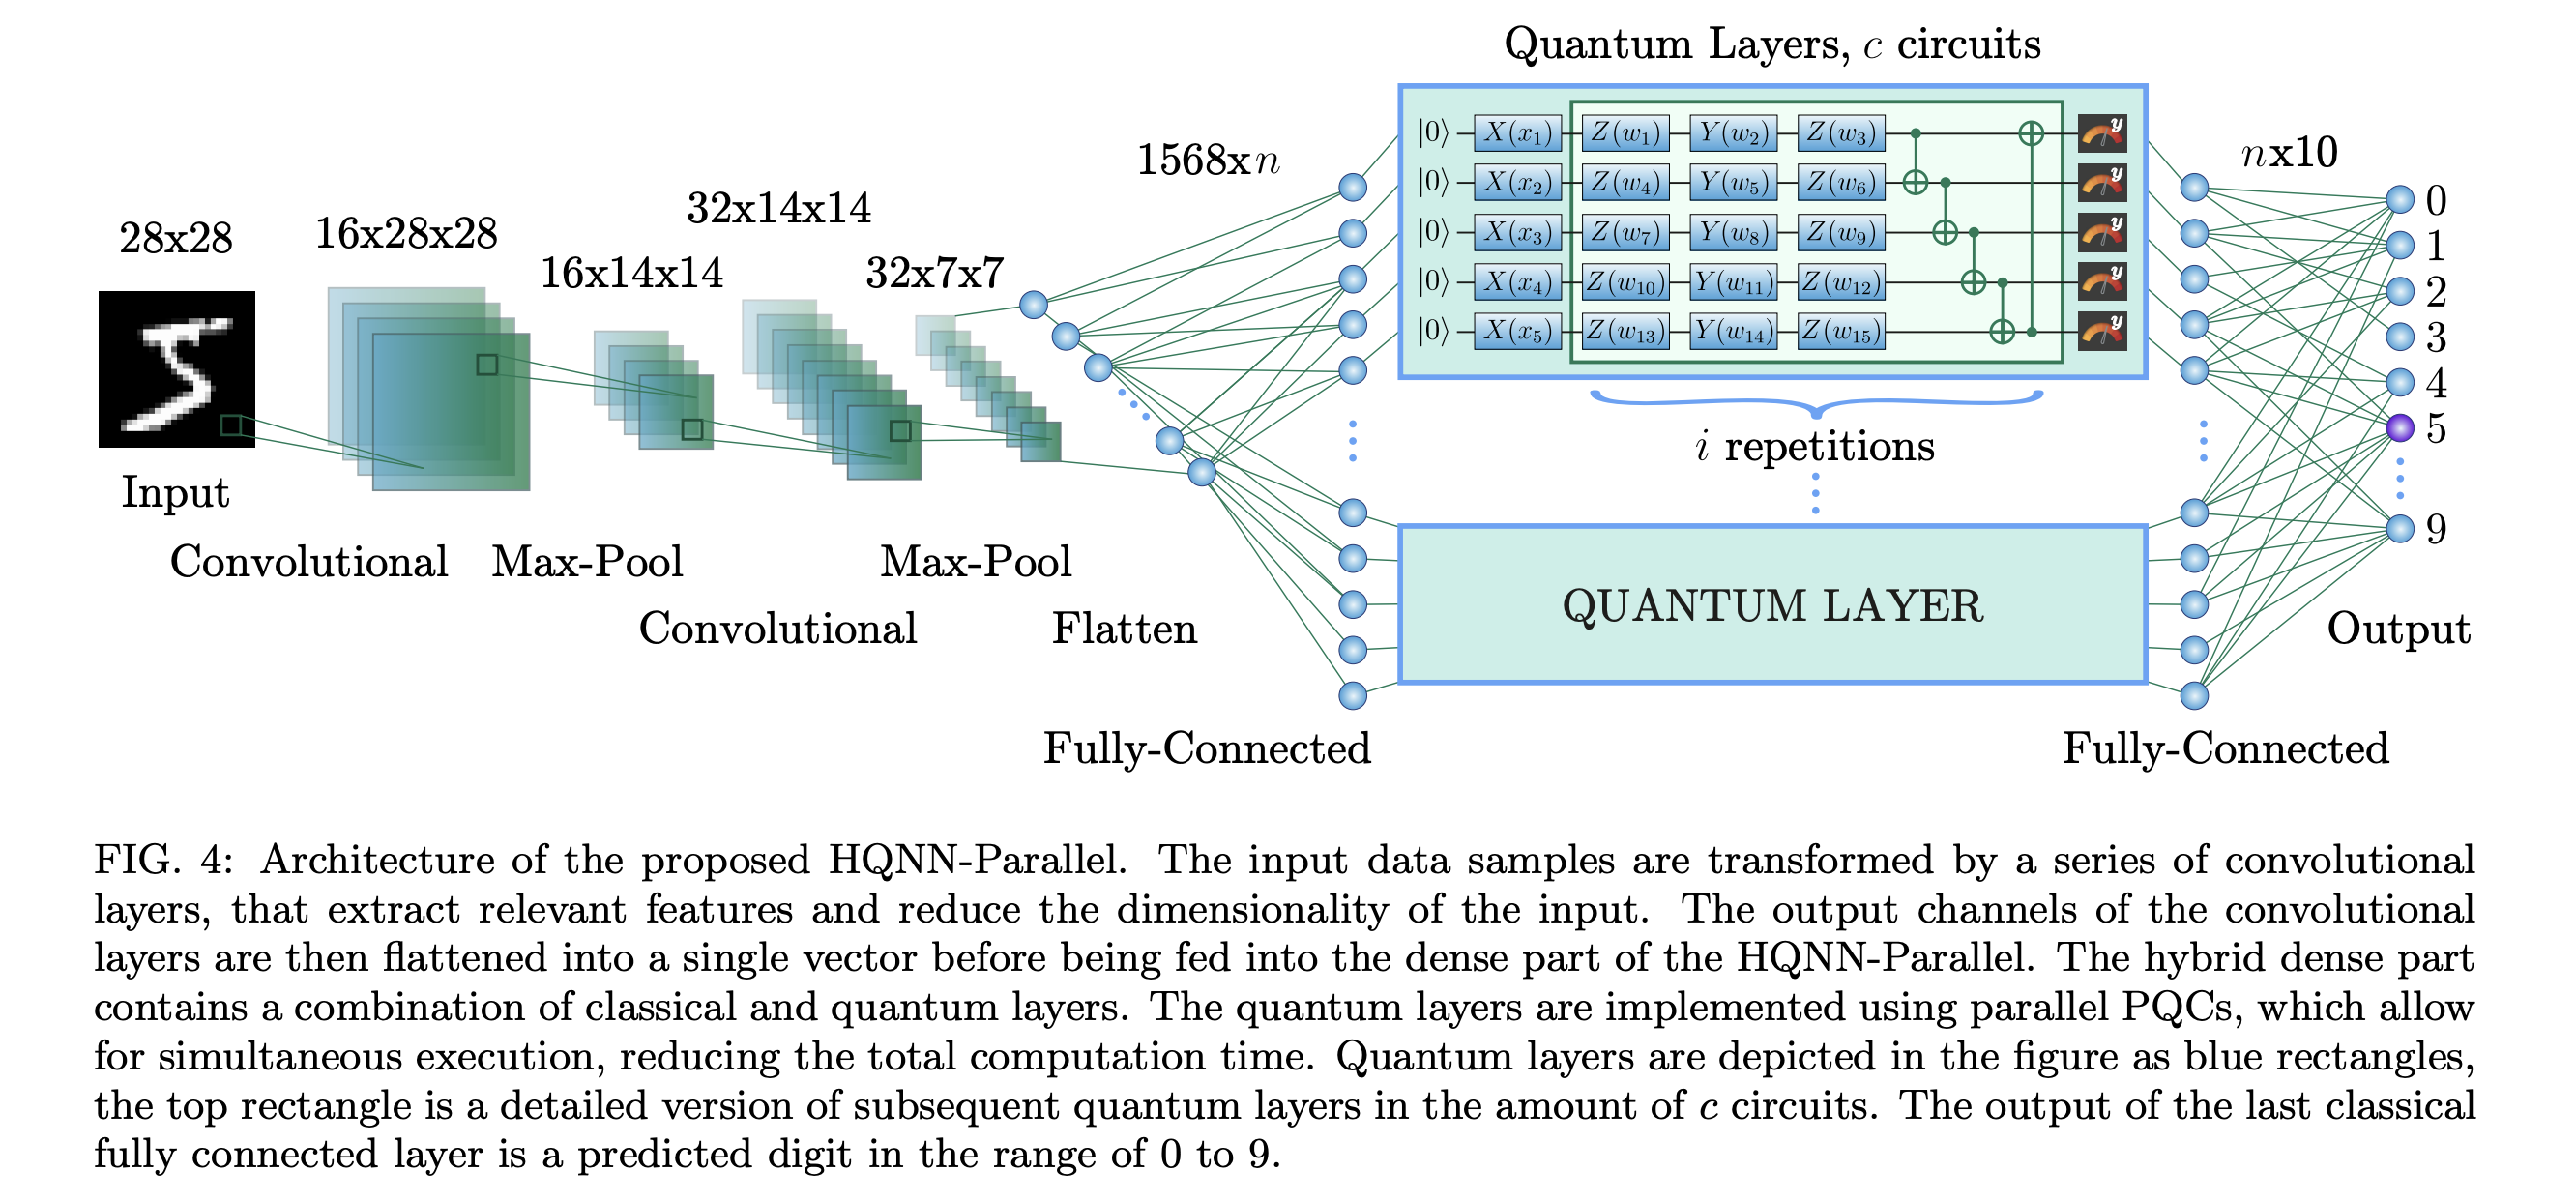


## Classical Convolutional Feature Extraction

```
FUNCTION ClassicalConvolutionalBlock(input_image):
    // First Convolutional Block
    conv1 = Conv2D(input_channels=1, output_channels=16, kernel_size=5×5,
                   stride=1, padding=2)(input_image)
    norm1 = BatchNormalization(conv1)
    relu1 = ReLU(norm1)
    pool1 = MaxPool2D(kernel_size=2×2)(relu1)  // Output: 16×14×14

    // Second Convolutional Block
    conv2 = Conv2D(input_channels=16, output_channels=32, kernel_size=5×5,
                   stride=1, padding=2)(pool1)
    norm2 = BatchNormalization(conv2)
    relu2 = ReLU(norm2)
    pool2 = MaxPool2D(kernel_size=2×2)(relu2)  // Output: 32×7×7

    // Flatten for dense layers
    flattened = Flatten(pool2)  // Output: 1568 features

    RETURN flattened
```


In [281]:
class ClassicalConvBlock(tf.keras.layers.Layer):
    '''
    Process input images through convolutional layers to extract features.
    
    Args:
        input_images: Either a single image of shape (1, 28, 28, 1) 
                     or a batch of images of shape (batch_size, 28, 28, 1)
    
    Returns:
        Extracted features of shape (batch_size, 1568) or (1, 1568) for a single image
    '''
    def __init__(self, name="classical_conv_block", **kwargs):
        super(ClassicalConvBlock, self).__init__(name=name, **kwargs)
        
        # First Convolutional Block
        self.conv1 = Conv2D(filters=16, # Number of features to extract
               kernel_size=5, # Creates a 5x5 kernel
               strides=1, # Kernel travels 1 pixel at a time
               padding='same' # Keeps the output size the same
               )
        self.bn1 = BatchNormalization() # After each convolution comes a batch normalization
        self.relu1 = ReLU() # Activation function
        self.pool1 = MaxPool2D(pool_size=2) # Downsizing the feature map to half its dimensions
        # Resulting feature map shape: (batch_size, 14, 14, 16) for MNIST


        # Second Convolutional Block
        self.conv2 = Conv2D(filters=32, # Number of features to extract
               kernel_size=5, # Same parameters as the first block
               strides=1,
               padding='same'
               )
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D(pool_size=2)
        # Resulting feature map shape: (batch_size, 7, 7, 32) for MNIST

        self.flatten = Flatten()
        # Resulting feature map shape: (batch_size, 1568) for MNIST

    def call(self, inputs):
        '''
        Forward pass
        '''
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        return self.flatten(x)


## Parallel Quantum Layers

```
FUNCTION ParallelQuantumLayers(features):
    // First classical dense layer to prepare quantum input
    dense_features = DenseLayer(input_size=1568, output_size=n)(features)
    dense_features = BatchNormalization(dense_features)
    dense_features = ReLU(dense_features)

    // Divide features into c parallel quantum circuits
    // where n = c × q (c circuits, q qubits each)
    quantum_inputs = Split(dense_features, num_parts=c)

    // Process each part through parallel quantum circuits
    quantum_outputs = []
    FOR i = 1 TO c:
        qc_output = QuantumCircuit(quantum_inputs[i], qubits=q, depth=d)
        quantum_outputs.append(qc_output)

    // Concatenate all quantum outputs
    concatenated_output = Concatenate(quantum_outputs)

    RETURN concatenated_output
```

### Individual Quantum Circuit within each layer:

```
FUNCTION ParallelCircuit(input_vector, qubits, depth):
    // Initialize quantum state
    state = |0⟩^⊗qubits

    // Angle embedding: encode classical data into quantum state
    FOR j = 1 TO qubits:
        state = RX(input_vector[j]) × state  // Rotate around Y-axis

    // Variational quantum circuit with depth repetitions
    FOR layer = 1 TO depth:
        // Trainable rotation gates
        FOR j = 1 TO qubits:
            state = RX(θ_x[layer][j]) × state
            state = RY(θ_y[layer][j]) × state
            state = RZ(θ_z[layer][j]) × state

        // Entangling gates (CNOT operations)
        FOR j = 1 TO qubits-1:
            state = CNOT(j, j+1) × state

    // Measurement: compute expectation values
    measurements = []
    FOR j = 1 TO qubits:
        expectation = ⟨state| Pauli_Y[j] |state⟩
        measurements.append(expectation)

    RETURN measurements
```


In [290]:
class ParallelQuantumLayer(tf.keras.layers.Layer):
    '''
    A Keras Layer for the parallel quantum circuits.
    '''
    def __init__(self, n_qubits, depth, device='local', shots=1024, name="parallel_quantum_layer", **kwargs):
        super(ParallelQuantumLayer, self).__init__(name=name, **kwargs)
        self.n_qubits = n_qubits
        self.depth = depth
        self.device = device
        self.shots = shots
        self.qnodes = [] # storing the circuits

    def build(self, input_shape):
        '''
        Create the trainable weights and quantum devices
        '''
        # Input shape is (batch_size, n_features)
        n_features = input_shape[-1]
        self.n_circuits = n_features // self.n_qubits

        if n_features % self.n_qubits != 0:
            raise ValueError("Number of features must be divisible by number of qubits.")

        # Define trainable theta parameters for all circuits
        n_theta_per_circuit = self.depth * 3 * self.n_qubits
        self.theta = self.add_weight(
            shape=(self.n_circuits, n_theta_per_circuit),
            initializer='random_uniform',
            dtype=tf.float32,
            trainable=True,
            name='theta'
        )

        # Create quantum nodes for each circuit
        dev, diff_method = self._select_backend()

        for i in range(self.n_circuits):
            # Create the QNode
            qnode = qml.QNode(self._circuit_template, dev, interface='tf', diff_method=diff_method)

            self.qnodes.append(qnode)

        # Display the first circuit for visualization
        print("Sample quantum circuit:")
        print(self.draw_circuit(0))

        super().build(input_shape)

    def _load_api_key(self):
        '''
        Load API key for IonQ backend
        '''
        try:
            with open('api-key.txt', 'r') as f:
                return f.read().strip()
        except FileNotFoundError:
            # Try getting from environment
            key_from_env = os.getenv("IONQ_API_KEY")
            if key_from_env:
                return key_from_env
            return None

    def _select_backend(self):
        if self.device == 'local':
            dev = qml.device('lightning.qubit', wires=self.n_qubits)
        else:
            # Try to setup IonQ device
            try:
                api_key = self._load_api_key()
                if api_key is None:
                    raise Exception("API key not found.")
                elif self.device == 'simulator':
                    dev = qml.device('ionq.simulator', wires=self.n_qubits, api_key=api_key, shots=self.shots, c_dtype=tf.float32)
                elif self.device.startswith('simulator.'):
                    dev = qml.device('ionq.simulator', target=self.device, wires=self.n_qubits, api_key=api_key, shots=self.shots, c_dtype=tf.float32)
                elif self.device.startswith('qpu.'):
                    dev = qml.device('ionq.qpu', target=self.device, wires=self.n_qubits, api_key=api_key, shots=self.shots, c_dtype=tf.float32)
                else:
                    raise ValueError("Invalid device name given")
                
            except:
                print(f"Error creating IonQ device. Using local simulation.")
                dev = qml.device('lightning.qubit', wires=self.n_qubits, c_dtype=tf.float32, shots=self.shots)

        diff_method = 'parameter-shift'

        return dev, diff_method


    def _circuit_template(self, inputs, theta_params):
        '''
        Template for quantum circuit. Uses parameter shifting and tensors
        '''
        # Cast inputs to float32 for consistency
        inputs = tf.cast(inputs, tf.float32)
        theta_params = tf.cast(theta_params, tf.float32)

        # Data encoding: Angle embedding using RX gates
        scaled_inputs = inputs * tf.constant(np.pi, dtype=tf.float32)
        qml.AngleEmbedding(scaled_inputs, wires=range(self.n_qubits), rotation='X')

        # Reshape theta parameters for readability
        theta_reshaped = tf.reshape(theta_params, (self.depth, 3, self.n_qubits))

        # Variational section of the circuit
        for layer in range(self.depth):
            # Apply rotation gates
            for j in range(self.n_qubits):
                qml.RZ(tf.cast(theta_reshaped[layer, 0, j], tf.float32), wires=j)
                qml.RY(tf.cast(theta_reshaped[layer, 1, j], tf.float32), wires=j)
                qml.RZ(tf.cast(theta_reshaped[layer, 2, j], tf.float32), wires=j)

            # Apply entangling gates
            for j in range(self.n_qubits - 1):
                qml.CNOT(wires=[j, j+1])

        # Return Y-basis expectations
        return [qml.expval(qml.PauliY(j)) for j in range(self.n_qubits)]

    # Remove the @tf.function decorator from the main call method
    def call(self, inputs):
        '''
        Forward pass for the layer
        '''
        # Set the output shape properly
        batch_size = tf.shape(inputs)[0]
        output_shape = (batch_size, self.n_circuits * self.n_qubits)

        # Use map_fn with explicit TensorFlow ops where possible
        output = tf.map_fn(
            self._process_sample,
            inputs,
            fn_output_signature=tf.TensorSpec(shape=(self.n_circuits * self.n_qubits), dtype=tf.float32)
        )
        
        return output
    
    # Create a separate method for processing individual samples
    def _process_sample(self, sample_features):
        # Ensure consistent float32 type
        sample_features = tf.cast(sample_features, tf.float32)

        # Divide features into parallel quantum circuits
        feature_chunks = tf.split(sample_features, self.n_circuits)
        
        # Create a list to store circuit outputs
        circuit_outputs = []
        
        # Process each chunk through the corresponding quantum circuit
        for i in range(self.n_circuits):
            # Extract features and parameters for this circuit
            chunk = tf.cast(feature_chunks[i], tf.float32)
            circuit_theta = tf.cast(self.theta[i], tf.float32)
            
            # Run the quantum circuit - this step cannot be traced by tf.function
            result = self.qnodes[i](chunk, circuit_theta)
            result = tf.cast(result, tf.float32)
            circuit_outputs.append(result)
        
        # Concatenate all circuit outputs
        return tf.concat(circuit_outputs, axis=0)

    def draw_circuit(self, circuit_index=0):
        '''
        Visualize one of the quantum circuits from the parallel quantum layer.
        '''
        if len(self.qnodes) == 0:
            raise ValueError("Circuits not created yet. Call build() first.")
        
        if circuit_index >= len(self.qnodes):
            raise ValueError(f"Invalid circuit index {circuit_index}. Must be < {len(self.qnodes)}.")
        
        # Create dummy inputs for visualization
        dummy_inputs = tf.zeros(self.n_qubits)
        dummy_theta = self.theta[circuit_index]
        
        # Draw the circuit using PennyLane's built-in drawing function
        circuit_drawing = qml.draw(self.qnodes[circuit_index])(dummy_inputs, dummy_theta)
        print(circuit_drawing)
    

## Final Classification Layer

```
FUNCTION ClassicalDenseLayer(quantum_features):
    // Final dense layer for classification
    logits = DenseLayer(input_size=n, output_size=10)(quantum_features)
    logits = BatchNormalization(logits)
    logits = ReLU(logits)

    // Convert to probabilities
    probabilities = Softmax(logits)

    RETURN probabilities
```


## Training Loop

```
ALGORITHM: Train_HQNN_Parallel
INPUT: Training dataset D, learning parameters
OUTPUT: Trained model parameters

FUNCTION TrainModel(dataset, epochs, learning_rate):
    // Initialize parameters
    classical_params = InitializeClassicalWeights()
    quantum_params = InitializeQuantumAngles()

    FOR epoch = 1 TO epochs:
        total_loss = 0

        FOR batch IN dataset:
            // Forward pass
            predictions = HQNN_Parallel(batch.images)

            // Compute cross-entropy loss
            loss = CrossEntropyLoss(predictions, batch.labels)
            total_loss += loss

            // Backward pass
            // Classical gradients via backpropagation
            classical_grads = BackwardPass(loss, classical_params)

            // Quantum gradients via parameter shift rule
            quantum_grads = ParameterShiftRule(loss, quantum_params)

            // Update parameters
            classical_params = UpdateWeights(classical_params,
                                           classical_grads, learning_rate)
            quantum_params = UpdateWeights(quantum_params,
                                         quantum_grads, learning_rate)

        PRINT("Epoch:", epoch, "Loss:", total_loss)

    RETURN classical_params, quantum_params
```


In [291]:
class HQNNParallel(tf.keras.Model):
    """
    Hybrid Quantum Neural Network with Parallel Quantum Layers
    
    This model combines classical convolutional layers with parallel quantum circuits
    for classification tasks. The model is flexible and can work with different
    input sizes and number of classes.
    
    Args:
        n_qubits: Number of qubits per quantum circuit (default: 4)
        depth: Depth of each quantum circuit (default: 2)
        backend: Quantum backend to use (default: 'local')
        shots: Number of shots for quantum measurements (default: 1024)
        n_classes: Number of output classes (default: 10)
        conv_filters: Tuple of filter sizes for conv layers (default: (16, 32))
        kernel_size: Kernel size for convolutions (default: 5)
        pool_size: Pool size for max pooling (default: 2)
        quantum_features: Number of features for quantum layer input (default: None - auto-calculated)
    """
    
    def __init__(self, 
                 n_qubits=4, 
                 depth=2, 
                 backend='local', 
                 shots=1024,
                 n_classes=10,
                 quantum_features=None,
                 **kwargs):
        super(HQNNParallel, self).__init__(**kwargs)
        
        # Store quantum parameters
        self.n_qubits = n_qubits
        self.depth = depth
        self.backend = backend
        self.shots = shots
        self.n_classes = n_classes
        self.quantum_features = quantum_features
        
        # Build classical convolutional layers
        self.conv_block = ClassicalConvBlock(name='conv_block')
        
        # The quantum layer will be built during first call when we know the feature size
        self.quantum_layer = None
        self.quantum_dense = None
        
        # Build final classification layers
        self.final_dense = Dense(n_classes, name='final_dense')
        self.final_bn = BatchNormalization(name='final_bn')
        self.final_relu = ReLU(name='final_relu')
        self.final_softmax = Softmax(name='final_softmax')
    
    def build(self, input_shape):
        """Build the model layers"""
        super(HQNNParallel, self).build(input_shape)
        
        # Calculate the output shape after conv block
        # This is needed to determine quantum layer input size
        dummy_input = tf.zeros((1,) + input_shape[1:])
        conv_output = self.conv_block(dummy_input)
        conv_features = conv_output.shape[-1]
        
        # Determine quantum features size
        if self.quantum_features is None:
            # Make it divisible by n_qubits
            self.quantum_features = (conv_features // self.n_qubits) * self.n_qubits
        
        # Build quantum preprocessing dense layer
        self.quantum_dense = tf.keras.Sequential([
            Dense(self.quantum_features, name='quantum_dense'),
            BatchNormalization(name='quantum_bn'),
            ReLU(name='quantum_relu')
        ], name='quantum_preprocessing')
        
        # Build quantum layer
        self.quantum_layer = ParallelQuantumLayer(
            n_qubits=self.n_qubits,
            depth=self.depth,
            device=self.backend,
            shots=self.shots,
            name='quantum_layer'
        )
        
        # Build quantum preprocessing layer
        _ = self.quantum_dense(conv_output)
        
        # Build quantum layer
        quantum_output = self.quantum_layer(tf.zeros((1, self.quantum_features)))
        
        # Build final layers using call pattern
        quantum_output_size = self.quantum_layer.n_circuits * self.n_qubits
        x = self.final_dense(tf.zeros((1, quantum_output_size)))
        x = self.final_bn(x)
        _ = self.final_relu(x)
    
    def call(self, inputs, training=None):
        """Forward pass through the model"""
        # Classical convolutional feature extraction
        conv_features = self.conv_block(inputs, training=training)
        
        # Prepare features for quantum processing
        quantum_input = self.quantum_dense(conv_features, training=training)
        
        # Quantum processing
        quantum_output = self.quantum_layer(quantum_input, training=training)
        
        # Final classification
        x = self.final_dense(quantum_output, training=training)
        x = self.final_bn(x, training=training)
        x = self.final_relu(x, training=training)
        probabilities = self.final_softmax(x, training=training)
        
        return probabilities
    
    def get_config(self):
        """Get model configuration for serialization"""
        config = super(HQNNParallel, self).get_config()
        config.update({
            'n_qubits': self.n_qubits,
            'depth': self.depth,
            'backend': self.backend,
            'shots': self.shots,
            'n_classes': self.n_classes,
            'quantum_features': self.quantum_features
        })
        return config
    
    def summary_extended(self):
        """Extended summary showing quantum parameters"""
        self.summary()
        print(f"\nQuantum Parameters:")
        print(f"  Number of qubits per circuit: {self.n_qubits}")
        print(f"  Circuit depth: {self.depth}")
        print(f"  Backend: {self.backend}")
        print(f"  Shots: {self.shots}")
        print(f"  Number of quantum circuits: {self.quantum_layer.n_circuits if self.quantum_layer else 'Not built'}")
        print(f"  Total quantum features: {self.quantum_features}")
        
    def compile_for_training(self, learning_rate=0.001):
        """Compile the model with appropriate settings for training"""
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=['accuracy', 'categorical_crossentropy']
        )
        
    def predict_classes(self, x):
        """Predict class labels for input data"""
        probabilities = self.predict(x)
        return tf.argmax(probabilities, axis=1)
    
    def predict_with_confidence(self, x):
        """Predict classes with confidence scores"""
        probabilities = self.predict(x)
        predicted_classes = tf.argmax(probabilities, axis=1)
        confidence_scores = tf.reduce_max(probabilities, axis=1)
        return predicted_classes, confidence_scores

# Using the HQNNParallel Model

## Model Creation and Basic Usage

The `HQNNParallel` class provides a complete `tf.keras.Model` implementation that can be used for training and inference. Here's how to use it:


In [292]:
def load_mnist_dataset(batch_size=32):
  '''
    Load the MNIST dataset and preprocess it for the model.

    Args:
        batch_size: Number of images per batch

    Returns:
        train_dataset: Preprocessed training dataset
        test_dataset: Preprocessed testing dataset

  '''
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

  # Normalize and reshape the data
  x_train = x_train[..., tf.newaxis].astype('float32') / 255.0  # Shape: (60000, 28, 28, 1)
  x_test = x_test[..., tf.newaxis].astype('float32') / 255.0    # Shape: (10000, 28, 28, 1)

  # One-hot encode the labels
  y_train = tf.one_hot(y_train, depth=10)  # Shape: (60000, 10)
  y_test = tf.one_hot(y_test, depth=10)    # Shape: (10000, 10)

  # Create TensorFlow datasets
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

  # Shuffle, batch, and prefetch the datasets
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [293]:
def create_and_test_hqnn_model():
    """
    Example of how to create and use the HQNNParallel model
    """
    # Load dataset
    print("Loading MNIST dataset...")
    train_dataset, test_dataset = load_mnist_dataset(batch_size=32)
    
    # Get a sample to determine input shape
    for sample_images, sample_labels in train_dataset.take(1):
        input_shape = sample_images.shape[1:]  # (28, 28, 1)
        break
    
    print(f"Input shape: {input_shape}")
    
    # Create the model
    print("Creating HQNNParallel model...")
    model = HQNNParallel(
        n_qubits=2,           # Use 2 qubits for faster testing
        depth=1,              # Use depth 1 for faster testing
        backend='local',      # Use local simulator
        shots=1024,           # Number of quantum shots
        n_classes=10,         # MNIST has 10 classes
        quantum_features=8    # Use 8 quantum features (divisible by 2 qubits)
    )
    
    # Build the model by calling it once
    print("Building model...")
    dummy_input = tf.zeros((1,) + input_shape)
    _ = model(dummy_input)
    
    # Show model summary
    print("\nModel Summary:")
    model.summary_extended()
    
    # Compile for training
    print("\nCompiling model for training...")
    model.compile_for_training(learning_rate=0.001)
    
    return model, train_dataset, test_dataset

def train_hqnn_model(model, train_dataset, test_dataset, epochs=2):
    """
    Example of how to train the HQNNParallel model
    """
    print(f"Training model for {epochs} epochs...")

    # Set up callbacks for training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]
    
    # Use try-except block to capture and diagnose any errors
    try:
        # Check the model's trainable variables before fitting
        print(f"Model has {len(model.trainable_variables)} trainable variables")
        for i, var in enumerate(model.trainable_variables[:3]):  # Show first few variables
            print(f"Variable {i}: shape={var.shape}, dtype={var.dtype}")
        
        # Convert datasets to ensure float32 types
        def ensure_float32(x, y):
            return tf.cast(x, tf.float32), y
            
        train_data_fixed = train_dataset.take(10).map(ensure_float32)
        test_data_fixed = test_dataset.take(5).map(ensure_float32)
        
        # Train the model
        history = model.fit(
            train_data_fixed,
            epochs=epochs,
            validation_data=test_data_fixed,
            verbose=1,
            callbacks=callbacks
        )
        
        return history
        
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_hqnn_predictions(model, test_dataset):
    """
    Example of how to use the trained model for predictions
    """
    print("Testing model predictions...")
    
    # Get a test batch
    for test_images, test_labels in test_dataset.take(1):
        break
    
    # Make predictions
    print("Making predictions...")
    probabilities = model.predict(test_images[:5])  # Predict on first 5 samples
    predicted_classes, confidence_scores = model.predict_with_confidence(test_images[:5])
    
    # Show results
    print("\nPrediction Results:")
    for i in range(5):
        true_label = tf.argmax(test_labels[i]).numpy()
        predicted_label = predicted_classes[i].numpy()
        confidence = confidence_scores[i].numpy()
        
        print(f"Sample {i+1}:")
        print(f"  True label: {true_label}")
        print(f"  Predicted label: {predicted_label}")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  Correct: {true_label == predicted_label}")
        print()

def save_and_load_model_example(model):
    """
    Example of how to save and load the model
    """
    # Save the model
    model_path = "hqnn_parallel_model"
    print(f"Saving model to {model_path}...")
    model.save_weights(model_path)
    
    # Create a new model instance
    new_model = HQNNParallel(
        n_qubits=2,
        depth=1,
        backend='local',
        shots=1024,
        n_classes=10,
        quantum_features=8
    )
    
    # Build the new model
    dummy_input = tf.zeros((1, 28, 28, 1))
    _ = new_model(dummy_input)
    
    # Load the weights
    print("Loading model weights...")
    new_model.load_weights(model_path)
    
    print("Model successfully saved and loaded!")
    return new_model

In [294]:
model, train_dataset, test_dataset = create_and_test_hqnn_model()

Loading MNIST dataset...


2025-07-17 09:24:13,256 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Input shape: (28, 28, 1)
Creating HQNNParallel model...
Building model...
Sample quantum circuit:
0: ─╭AngleEmbedding(M0)──RZ(-0.02)──RY(0.01)──RZ(-0.03)─╭●─┤  <Y>
1: ─╰AngleEmbedding(M0)──RZ(-0.05)──RY(0.00)──RZ(-0.04)─╰X─┤  <Y>

M0 = 
[0. 0.]
None
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,333 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,419 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,502 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,578 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,641 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,720 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,782 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,868 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,928 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:13,996 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:14,072 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:14,147 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:14,207 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:14,274 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:14,336 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Model Summary:


Model: "hqnn_parallel_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block (ClassicalConvBlock) │ ?                      │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_dense (Dense)             │ (1, 10)                │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_bn (BatchNormalization)   │ (1, 10)                │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_relu (ReLU)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_softmax (Softmax)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_preprocessing           │ (1, 8)                 │        12,584 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer                   │ ?                      │            24 │
│ (ParallelQuantumLayer)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,178 (102.26 KB)

 Trainable params: 26,046 (101.74 KB)

 Non-trainable params: 132 (528.00 B)


Quantum Parameters:
  Number of qubits per circuit: 2
  Circuit depth: 1
  Backend: local
  Shots: 1024
  Number of quantum circuits: 4
  Total quantum features: 8

Compiling model for training...


In [295]:
train_hqnn_model(model, train_dataset, test_dataset)

Training model for 2 epochs...
Model has 17 trainable variables
Variable 0: shape=(5, 5, 1, 16), dtype=float32
Variable 1: shape=(16,), dtype=float32
Variable 2: shape=(16,), dtype=float32
Epoch 1/2
Error during training: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.


Traceback (most recent call last):
  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/3375477411.py", line 68, in train_hqnn_model
    history = model.fit(
              ^^^^^^^^^^
  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in train_step
    gradients = tape.gradient(loss, trainable_weights)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.


In [296]:
def test_hqnn_model_basic():
    """
    Simple test to verify the HQNNParallel model works using real MNIST data
    """
    print("Testing HQNNParallel model with real MNIST data...")
    
    # Load MNIST dataset
    print("Loading MNIST dataset...")
    train_dataset, test_dataset = load_mnist_dataset(batch_size=32)
    
    # Get a few real samples from the dataset
    for sample_images, sample_labels in train_dataset.take(1):
        # Use only the first 3 samples
        real_input = sample_images[:3]  # Shape: (3, 28, 28, 1)
        real_labels = sample_labels[:3]  # Shape: (3, 10)
        break
    
    print(f"Input shape: {real_input.shape}")
    print(f"Labels shape: {real_labels.shape}")
    
    # Show the true labels
    true_labels = tf.argmax(real_labels, axis=1).numpy()
    print(f"True labels: {true_labels}")
    
    # Create a simple model
    model = HQNNParallel(
        n_qubits=2,
        depth=1,
        backend='local',
        shots=100,  # Use fewer shots for faster testing
        n_classes=10,
        quantum_features=4  # Small number for testing
    )
    
    # Test forward pass
    print("\nRunning forward pass...")
    output = model(real_input)
    
    print(f"Output shape: {output.shape}")
    print(f"Output probabilities sum to 1: {tf.reduce_sum(output, axis=1).numpy()}")
    
    # Test compilation
    print("\nTesting model compilation...")
    model.compile_for_training()
    
    # Test prediction methods
    print("\nTesting prediction methods...")
    predicted_classes = model.predict_classes(real_input)
    pred_classes, confidence = model.predict_with_confidence(real_input)
    
    print(f"Predicted classes: {predicted_classes.numpy()}")
    print(f"Confidence scores: {confidence.numpy()}")
    
    # Show detailed results for each sample
    print("\nDetailed Results:")
    for i in range(3):
        print(f"Sample {i+1}:")
        print(f"  True label: {true_labels[i]}")
        print(f"  Predicted label: {predicted_classes[i].numpy()}")
        print(f"  Confidence: {confidence[i].numpy():.4f}")
        print(f"  Correct: {true_labels[i] == predicted_classes[i].numpy()}")
        print(f"  Full probability distribution: {output[i].numpy()}")
        print()
    
    # Test with a single sample
    print("Testing with single sample...")
    single_sample = real_input[:1]  # Shape: (1, 28, 28, 1)
    single_output = model(single_sample)
    print(f"Single sample output shape: {single_output.shape}")
    print(f"Single sample prediction: {model.predict_classes(single_sample).numpy()}")
    
    print("Basic test with real MNIST data completed successfully!")
    return model, real_input, real_labels

# Run the basic test with real data
test_model, test_images, test_labels = test_hqnn_model_basic()

Testing HQNNParallel model with real MNIST data...
Loading MNIST dataset...


2025-07-17 09:24:26,531 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Input shape: (3, 28, 28, 1)
Labels shape: (3, 10)
True labels: [6 2 8]

Running forward pass...
Sample quantum circuit:
0: ─╭AngleEmbedding(M0)──RZ(-0.03)──RY(-0.01)──RZ(-0.04)─╭●─┤  <Y>
1: ─╰AngleEmbedding(M0)──RZ(-0.03)──RY(0.00)───RZ(-0.02)─╰X─┤  <Y>

M0 = 
[0. 0.]
None
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,594 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,656 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,725 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,803 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,866 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:26,945 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,006 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,076 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,136 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,283 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,374 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,452 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,515 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,593 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:27,657 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Output shape: (3, 10)
Output probabilities sum to 1: [1. 1. 1.]

Testing model compilation...

Testing prediction methods...


InvalidArgumentError: Graph execution error:

Detected at node hqnn_parallel_56_1/quantum_layer_1/map/while/PyFunc defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/67370485.py", line 76, in <module>

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/67370485.py", line 48, in test_hqnn_model_basic

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/4103887298.py", line 148, in predict_classes

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 250, in one_step_on_data

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 105, in predict_step

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/4103887298.py", line 104, in call

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/1328605107.py", line 130, in call

  File "/var/folders/xl/4k06phkd0zq_dzht7nr6yvmr0000gn/T/ipykernel_61327/1328605107.py", line 156, in _process_sample

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/qnode.py", line 882, in __call__

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/qnode.py", line 855, in _impl_call

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/execution.py", line 244, in execute

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/run.py", line 301, in run

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/interfaces/tensorflow_autograph.py", line 355, in execute

  File "/Users/jaimanmunshi/Desktop/VSCode-Workspace/QLab/.venv/lib/python3.12/site-packages/pennylane/workflow/interfaces/tensorflow_autograph.py", line 206, in _execute

0-th value returned by pyfunc_182 is float, but expects double
	 [[{{node hqnn_parallel_56_1/quantum_layer_1/map/while/PyFunc}}]] [Op:__inference_one_step_on_data_distributed_103198]

## Advantages of the HQNNParallel Model Class

The new `HQNNParallel` class provides several advantages over the previous function-based implementation:

### 1. **Full Keras Integration**

- Can be trained using standard Keras training loops (`model.fit()`)
- Supports all Keras callbacks (EarlyStopping, ReduceLROnPlateau, etc.)
- Compatible with Keras optimizers and loss functions
- Easy to save and load model weights

### 2. **Flexible Architecture**

- **No hardcoded input sizes**: Works with any input dimensions
- **Configurable quantum parameters**: Easily adjust qubits, depth, backend, etc.
- **Modular design**: Each component can be modified independently
- **Scalable**: Can handle different numbers of classes and features

### 3. **Training and Inference**

- **Cross-entropy loss**: Properly configured for classification
- **Gradient computation**: Supports backpropagation through quantum layers
- **Batch processing**: Efficient handling of batches during training
- **Prediction methods**: Easy class prediction and confidence scoring

### 4. **Key Features**

- `compile_for_training()`: Quick setup for training
- `predict_classes()`: Direct class prediction
- `predict_with_confidence()`: Prediction with confidence scores
- `summary_extended()`: Detailed model information including quantum parameters
- `get_config()`: Serialization support

### 5. **Usage Examples**

```python
# Create model
model = HQNNParallel(n_qubits=4, depth=2, n_classes=10)

# Compile for training
model.compile_for_training(learning_rate=0.001)

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Make predictions
predictions = model.predict(test_data)
classes, confidence = model.predict_with_confidence(test_data)

# Save model
model.save_weights('my_hqnn_model')
```

### 6. **Quantum Layer Integration**

- Seamless integration with classical layers
- Proper gradient flow for end-to-end training
- Support for different quantum backends (local, IonQ, etc.)
- Configurable quantum measurement strategies


In [297]:
# Simple training example (uncomment to run)
def simple_training_example():
    """
    Simple example showing how to train the HQNNParallel model
    """
    print("Creating model and loading data...")
    
    # Load a small subset of data for quick training
    train_dataset, test_dataset = load_mnist_dataset(batch_size=16)
    
    # Create model with minimal parameters for fast training
    model = HQNNParallel(
        n_qubits=2,
        depth=1,
        backend='local',
        shots=100,
        n_classes=10,
        quantum_features=4
    )
    
    # Build the model
    for sample_batch in train_dataset.take(1):
        _ = model(sample_batch[0][:1])  # Build with single sample
        break
    
    # Show model summary
    print("\nModel Summary:")
    model.summary_extended()
    
    # Compile for training
    print("\nCompiling model...")
    model.compile_for_training(learning_rate=0.01)
    
    # Train for a few steps
    print("\nTraining model for 1 epoch on small dataset...")
    history = model.fit(
        train_dataset.take(5),  # Use only 5 batches
        epochs=1,
        validation_data=test_dataset.take(2),  # Use 2 batches for validation
        verbose=1
    )
    
    # Test predictions
    print("\nTesting predictions...")
    for test_batch in test_dataset.take(1):
        test_images, test_labels = test_batch
        predictions = model.predict(test_images[:3])  # Predict on 3 samples
        predicted_classes = model.predict_classes(test_images[:3])
        
        print("Sample predictions:")
        for i in range(3):
            true_label = tf.argmax(test_labels[i]).numpy()
            pred_label = predicted_classes[i].numpy()
            confidence = tf.reduce_max(predictions[i]).numpy()
            
            print(f"  Sample {i+1}: True={true_label}, Pred={pred_label}, Conf={confidence:.3f}")
        break
    
    return model, history

# Uncomment the next line to run the training example
trained_model, training_history = simple_training_example()

Creating model and loading data...


2025-07-17 09:24:38,592 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Sample quantum circuit:
0: ─╭AngleEmbedding(M0)──RZ(0.04)───RY(-0.04)──RZ(0.00)─╭●─┤  <Y>
1: ─╰AngleEmbedding(M0)──RZ(-0.01)──RY(0.04)───RZ(0.03)─╰X─┤  <Y>

M0 = 
[0. 0.]
None
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:38,668 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:38,753 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:38,824 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:38,898 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:38,963 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:39,037 - WARNING - AutoGraph could not transform TransformProgram(_expand_transform_param_shift) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-07-17 09:24:39,121 - WARNING - AutoGraph could not transform TransformProgram(validate_measurements, validate_observables, mid_circuit_measurements, validate_device_wires, decompose, broadcast_expand, convert_to_numpy_parameters) and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Model Summary:


Model: "hqnn_parallel_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block (ClassicalConvBlock) │ ?                      │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_dense (Dense)             │ (1, 10)                │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_bn (BatchNormalization)   │ (1, 10)                │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_relu (ReLU)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_softmax (Softmax)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_preprocessing           │ (1, 4)                 │         6,292 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer                   │ ?                      │            12 │
│ (ParallelQuantumLayer)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,834 (77.48 KB)

 Trainable params: 19,710 (76.99 KB)

 Non-trainable params: 124 (496.00 B)


Quantum Parameters:
  Number of qubits per circuit: 2
  Circuit depth: 1
  Backend: local
  Shots: 100
  Number of quantum circuits: 2
  Total quantum features: 4

Compiling model...

Training model for 1 epoch on small dataset...


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.